In [927]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
import pylab

In [928]:
pylab.rcParams['figure.figsize'] = 10, 8
%matplotlib inline

In [929]:
df = pd.read_csv('./data/data_cleaned/combined_data_state_level_na_filled_from_2000.csv')
df['unknown_expenditure'] = df.total_expenditure - df.support_services_expenditure - df.instruction_expenditure\
                            - df.other_expenditure - df.capital_outlay_expenditure
df.head()

,state,year,enroll,total_revenue,federal_revenue,state_revenue,local_revenue,total_expenditure,instruction_expenditure,support_services_expenditure,...,pupil_teacher_ratio,pub_high_school_graduates,expenditure_per_pupil,edu_expenditure_percent_gov_income,population,gdp_per_capita,income_per_capita,known_property_crimes,unemployment_rate,unknown_expenditure
0,Alabama,2000,730184.0,4885917,425978,3003814,1456125,5003267,2551713,1319053,...,15.354315,37819.0,5758.428628,0.250000,4452173.0,33284,24258,151127.0,0.045750,72689.0
1,Alaska,2000,132822.0,1313510,199520,774194,339796,1386904,717725,417637,...,16.922491,6615.0,9668.161193,0.123966,627963.0,57184,31651,21074.0,0.063583,20214.0
2,Arizona,2000,814807.0,5479168,534619,2481089,2463460,5397194,2488932,1573568,...,19.750846,38304.0,5478.359673,0.190000,5160586.0,39185,26232,271269.0,0.039750,295598.0
3,Arkansas,2000,450751.0,2844855,254735,2126099,464021,2683400,1531232,804253,...,14.084370,27335.0,5627.818516,0.195000,2678588.0,31834,22784,97501.0,0.042750,63029.0
4,California,2000,5941946.0,46628207,4024940,26877920,15725347,45829753,23514388,12429070,...,20.605279,309866.0,6400.553393,0.260000,33987977.0,48223,33095,1054010.0,0.049583,1767251.0


In [930]:
df = df.dropna(how = 'any', axis = 0)

In [931]:
df.isnull().sum()

state                                 0
year                                  0
enroll                                0
total_revenue                         0
federal_revenue                       0
state_revenue                         0
local_revenue                         0
total_expenditure                     0
instruction_expenditure               0
support_services_expenditure          0
other_expenditure                     0
capital_outlay_expenditure            0
avg_attendence_elem_secd_schools      0
teachers_elem_secd_schools            0
high_school_completers_18_to_24       0
bachelor_completers_over_25           0
pupil_teacher_ratio                   0
pub_high_school_graduates             0
expenditure_per_pupil                 0
edu_expenditure_percent_gov_income    0
population                            0
gdp_per_capita                        0
income_per_capita                     0
known_property_crimes                 0
unemployment_rate                     0


# 1. Revenue Prediction with Linear Model and Randomforest

## 1.1 Predict Revenue

In [612]:
df.columns

Index(['state', 'year', 'enroll', 'total_revenue', 'federal_revenue',
       'state_revenue', 'local_revenue', 'total_expenditure',
       'instruction_expenditure', 'support_services_expenditure',
       'other_expenditure', 'capital_outlay_expenditure',
       'avg_attendence_elem_secd_schools', 'teachers_elem_secd_schools',
       'high_school_completers_18_to_24', 'bachelor_completers_over_25',
       'pupil_teacher_ratio', 'pub_high_school_graduates',
       'expenditure_per_pupil', 'edu_expenditure_percent_gov_income',
       'population', 'gdp_per_capita', 'income_per_capita',
       'known_property_crimes', 'unemployment_rate', 'unknown_expenditure'],
      dtype='object')

In [613]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

In [614]:
all_features = [ 'year','enroll', 
       'avg_attendence_elem_secd_schools', 'teachers_elem_secd_schools',
       'high_school_completers_18_to_24', 'bachelor_completers_over_25',
       'pupil_teacher_ratio', 'pub_high_school_graduates',
       'edu_expenditure_percent_gov_income',
       'population', 'gdp_per_capita', 'income_per_capita',
       'known_property_crimes', 'unemployment_rate']

In [615]:
def RandomForestFeatureAnalysis(dataframe, response_name, n_forest = np.arange(50, 500, 20)):
    global all_features
    df_tree = dataframe.copy()
    feature = all_features.copy()
    if response_name in feature:
        feature.remove(response_name)
    if 'year' in feature:
        feature.remove('year')
    X = df_tree[feature]
    y = df_tree[response_name]
        
    feature_score = []
    
    for n in n_forest:
        tree = RandomForestRegressor(n_estimators=n).fit(X,y)
        feature_score.append(tree.feature_importances_)

    # Random forest R^2 plot VS num_of_forest
    plt.figure(figsize = (10, 8))
    plt.plot(n_forest, feature_score)
    plt.xlabel('RANDOM FOREST number of forests')
    plt.ylabel('feature importance')
    plt.title('Random forest feature importance\n VS number of  forests')
    plt.legend(feature,bbox_to_anchor = (1.7,1), loc = 'upper right')
    plt.show()
    
    
    feature_df = pd.DataFrame(np.c_[feature_score][-10:].mean(axis = 0), index = feature, columns=['importance'])

    plt.figure(figsize = (10, 8))
    _=sns.barplot(data = feature_df.reset_index().sort_values(by = 'importance',ascending = False ),
                x = 'importance', y = 'index', palette='Reds_r')
    _= plt.ylabel('features')
    _= plt.title('Feature Importance for \n' + response_name)
    plt.show()

### 1.1.1 Total revenue as response

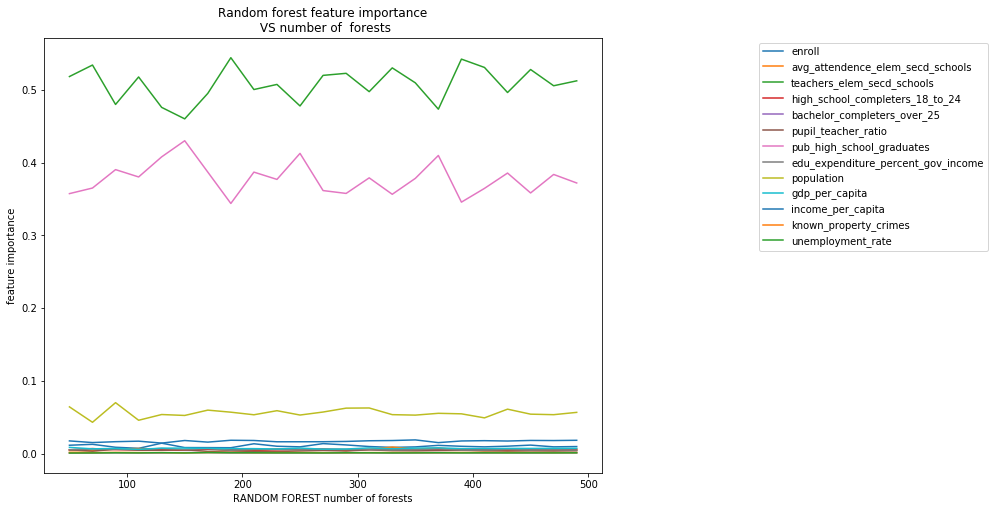

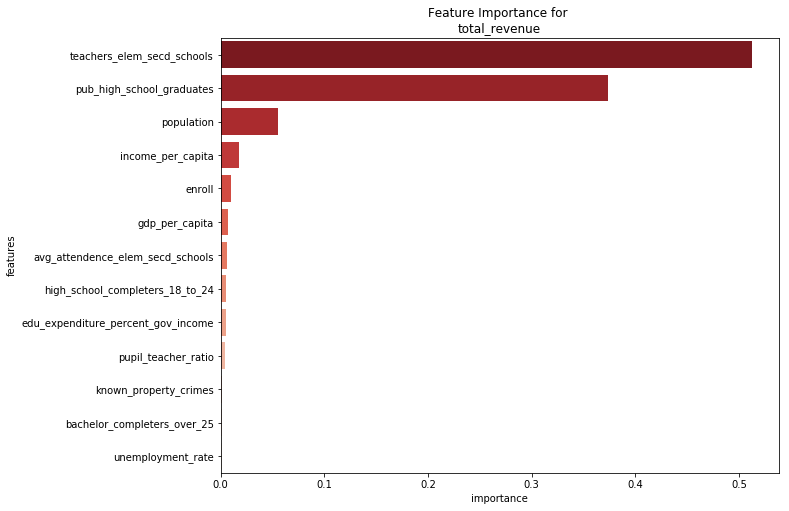

In [452]:
RandomForestFeatureAnalysis(df, 'total_revenue')

In [ ]:
X = df[['teachers_elem_secd_schools', 'pub_high_school_graduates']]
y = df['total_revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)
lm = LinearRegression(normalize=True)
lm.fit(X_train,y_train).score(X_test,y_test)

func = lambda x, y: x * lm.coef_[0] + y * lm.coef_[1] + lm.intercept_
pt_x = np.linspace(df.teachers_elem_secd_schools.min(), df.teachers_elem_secd_schools.max(), 100)
pt_y = np.linspace(df.pub_high_school_graduates.min(), df.pub_high_school_graduates.max(), 100)
meshx, meshy = np.meshgrid(pt_x, pt_y)
pt_z = np.array([func(x, y) for x, y in zip(meshx, meshy)])


Text(0.5,0,'total_revenue')

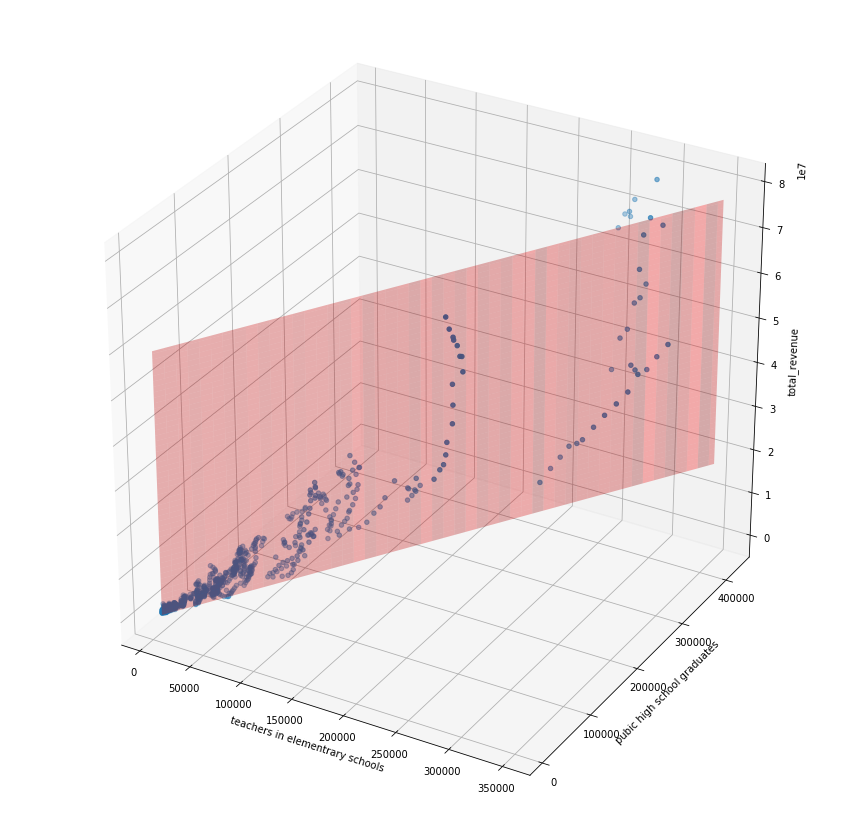

In [523]:
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.teachers_elem_secd_schools, df.pub_high_school_graduates, df.total_revenue)
#ax.scatter(df.teachers_elem_secd_schools, df.pub_high_school_graduates, lm.predict(X), c = 'red')
ax.plot_surface(pt_x, pt_y, pt_z, color = 'red', alpha = 0.3)
ax.set_xlabel('teachers in elementrary schools')
ax.set_ylabel('pubic high school graduates')
ax.set_zlabel('total_revenue')
#ax.view_init(0, 0)
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

### 1.1.2 Conclusion

In [524]:
lm.intercept_, lm.coef_

(-618700.9756648075, array([ 50.84578616, 141.31753154]))

$$Total\_Revenue = 50.85 \times[teachers\_elem\_secd\_schools + 141.32 \times pub\_high\_school\_graduates - 618700 $$

### 1.1.3 Federal revenue as response

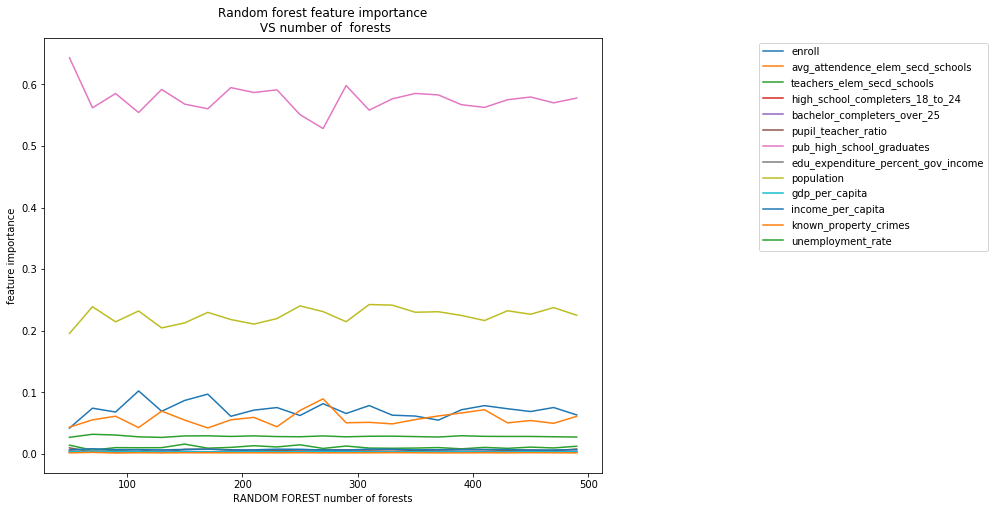

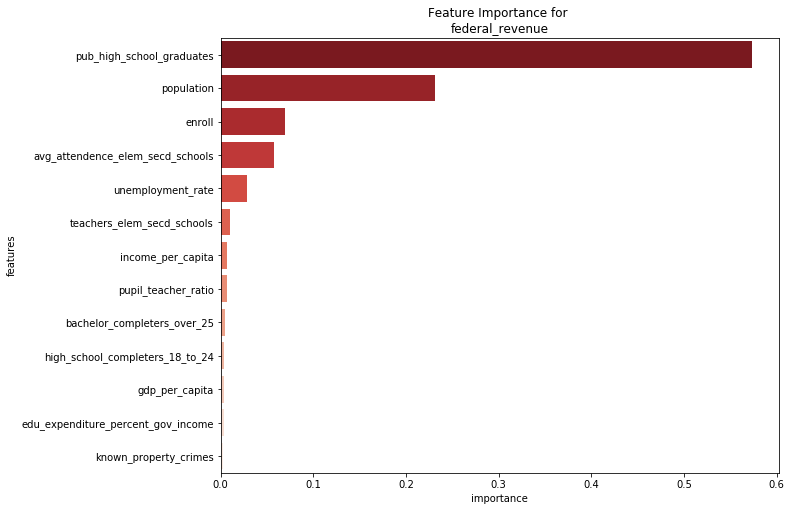

In [447]:
RandomForestFeatureAnalysis(df, 'federal_revenue')

In [533]:
X = df[['pub_high_school_graduates', 'population']]
y = df['federal_revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)
lm = LinearRegression(normalize=True)
lm = lm.fit(X_train,y_train)
print("Test accuracy: ", lm.score(X_test,y_test))

func = lambda x, y: x * lm.coef_[0] + y * lm.coef_[1] + lm.intercept_
pt_x = np.linspace(df.pub_high_school_graduates.min(), df.pub_high_school_graduates.max(), 100)
pt_y = np.linspace(df.population.min(), df.population.max(), 100)
meshx, meshy = np.meshgrid(pt_x, pt_y)
pt_z = np.array([func(x, y) for x, y in zip(meshx, meshy)])


Test accuracy:  0.9233815360795634


Text(0.5,0,'federal_revenue')

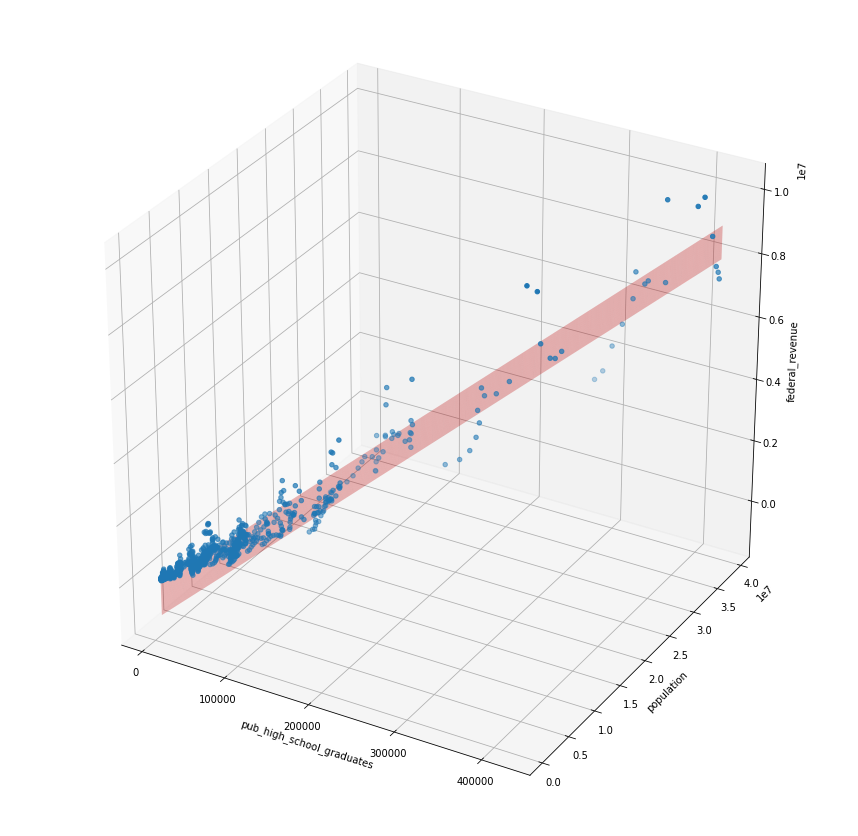

In [534]:
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.pub_high_school_graduates, df.population, df.federal_revenue)
#ax.scatter(df.teachers_elem_secd_schools, df.pub_high_school_graduates, lm.predict(X), c = 'red')
ax.plot_surface(pt_x, pt_y, pt_z, color = 'red', alpha = 0.3)
ax.set_xlabel('pub_high_school_graduates')
ax.set_ylabel('population')
ax.set_zlabel('federal_revenue')
#ax.view_init(0, 0)
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

### 1.1.4 Conclusion

In [536]:
lm.coef_, lm.intercept_

(array([21.63366915, -0.02725756]), -125452.48498492234)

$$federal\_Revenue = -0.02 \times population + 21.6 \times pub\_high\_school\_graduates - 125452 $$

### 1.1.5 State revenue as response

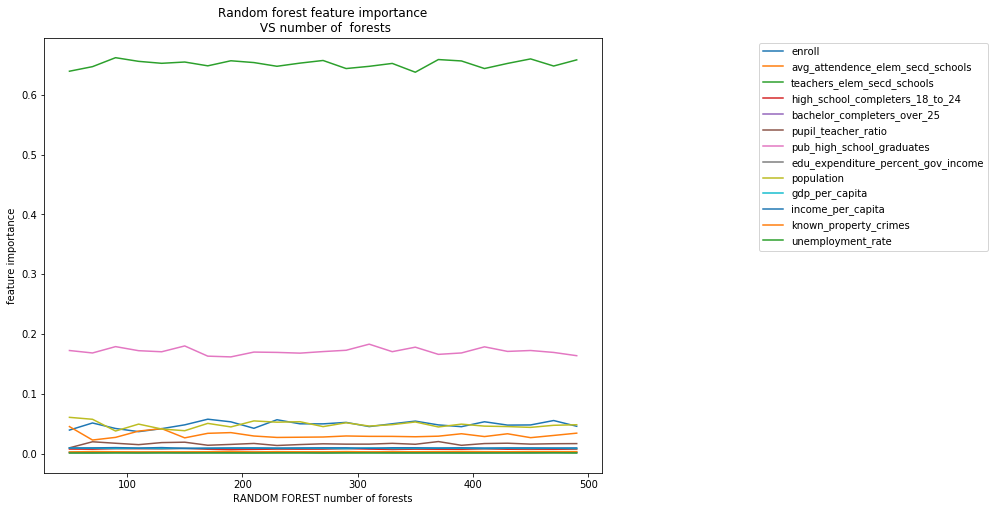

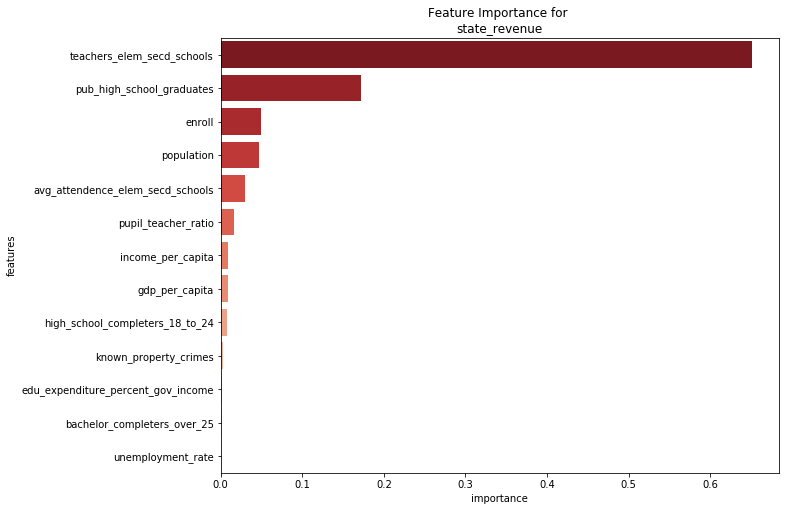

In [448]:
RandomForestFeatureAnalysis(df, 'state_revenue')

In [538]:
X = df[['teachers_elem_secd_schools', 'pub_high_school_graduates']]
y = df['state_revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)
lm = LinearRegression(normalize=True)
lm = lm.fit(X_train,y_train)
print("Test accuracy: ", lm.score(X_test,y_test))

func = lambda x, y: x * lm.coef_[0] + y * lm.coef_[1] + lm.intercept_
pt_x = np.linspace(df.teachers_elem_secd_schools.min(), df.teachers_elem_secd_schools.max(), 100)
pt_y = np.linspace(df.pub_high_school_graduates.min(), df.pub_high_school_graduates.max(), 100)
meshx, meshy = np.meshgrid(pt_x, pt_y)
pt_z = np.array([func(x, y) for x, y in zip(meshx, meshy)])


Test accuracy:  0.8934698317944371


Text(0.5,0,'state_revenue')

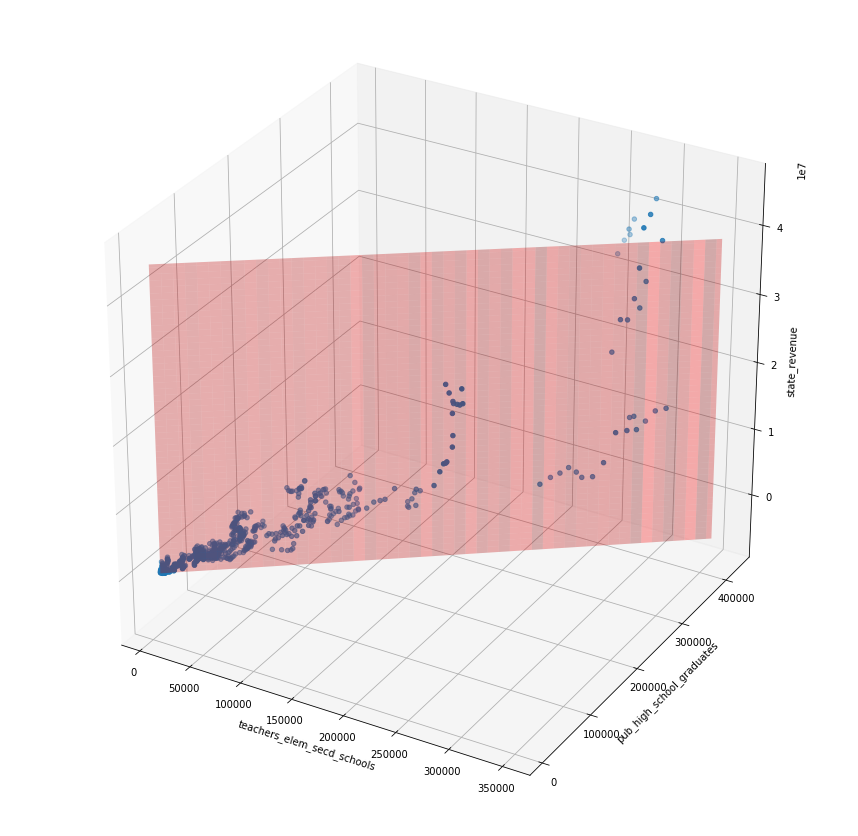

In [539]:
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.teachers_elem_secd_schools, df.pub_high_school_graduates, df.state_revenue)
#ax.scatter(df.teachers_elem_secd_schools, df.pub_high_school_graduates, lm.predict(X), c = 'red')
ax.plot_surface(pt_x, pt_y, pt_z, color = 'red', alpha = 0.3)
ax.set_xlabel('teachers_elem_secd_schools')
ax.set_ylabel('pub_high_school_graduates')
ax.set_zlabel('state_revenue')
#ax.view_init(0, 0)
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

### 1.1.6 Conclusion

In [540]:
lm.intercept_, lm.coef_

(-59368.20672455896, array([-18.35356074, 106.73557807]))

$$state\_Revenue = -18.35 \times teachers\_elem\_secd\_schools + 106.74 \times pub\_high\_school\_graduates - 59368 $$

### 1.1.7 Local revenue as response

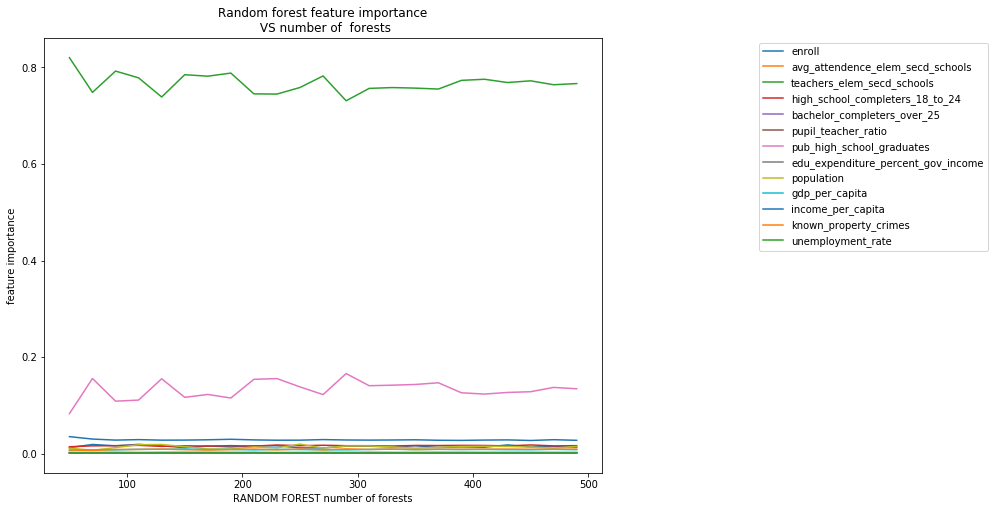

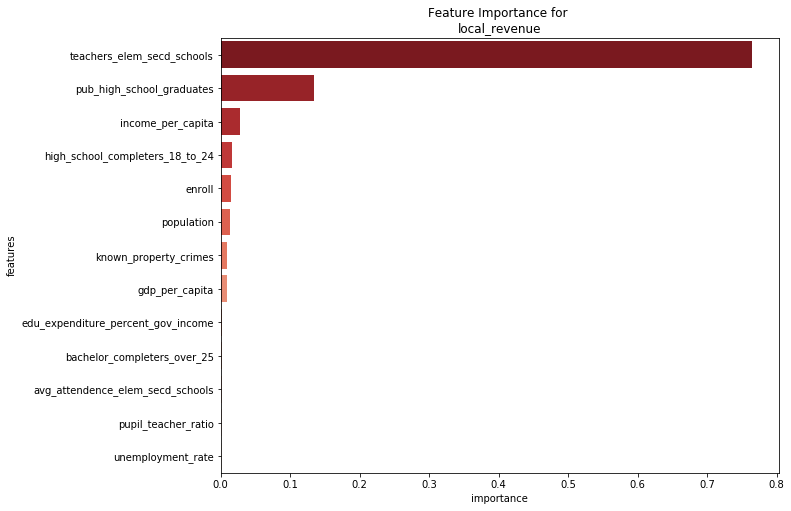

In [449]:
RandomForestFeatureAnalysis(df, 'local_revenue')

In [542]:
X = df[['teachers_elem_secd_schools', 'pub_high_school_graduates']]
y = df['local_revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)
lm = LinearRegression(normalize=True)
lm = lm.fit(X_train,y_train)
print("Test accuracy: ", lm.score(X_test,y_test))

func = lambda x, y: x * lm.coef_[0] + y * lm.coef_[1] + lm.intercept_
pt_x = np.linspace(df.teachers_elem_secd_schools.min(), df.teachers_elem_secd_schools.max(), 100)
pt_y = np.linspace(df.pub_high_school_graduates.min(), df.pub_high_school_graduates.max(), 100)
meshx, meshy = np.meshgrid(pt_x, pt_y)
pt_z = np.array([func(x, y) for x, y in zip(meshx, meshy)])


Test accuracy:  0.8337251774566361


Text(0.5,0,'local_revenue')

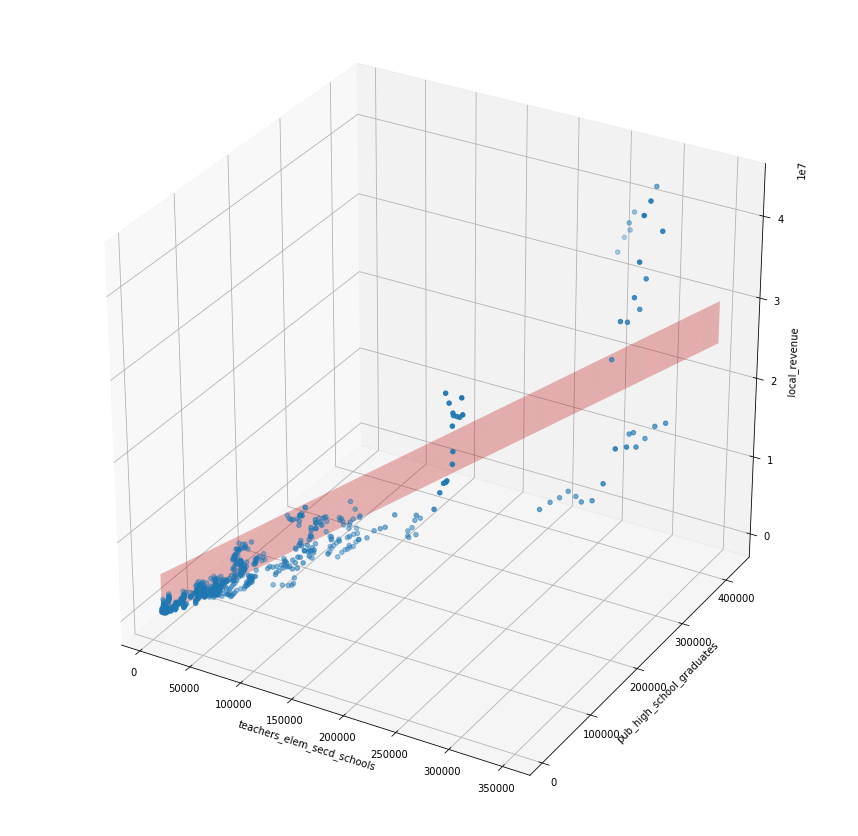

In [544]:
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.teachers_elem_secd_schools, df.pub_high_school_graduates, df.state_revenue)
#ax.scatter(df.teachers_elem_secd_schools, df.pub_high_school_graduates, lm.predict(X), c = 'red')
ax.plot_surface(pt_x, pt_y, pt_z, color = 'red', alpha = 0.3)
ax.set_xlabel('teachers_elem_secd_schools')
ax.set_ylabel('pub_high_school_graduates')
ax.set_zlabel('local_revenue')
#ax.view_init(0, 0)
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

### 1.1.8 Conclusion

In [546]:
lm.coef_, lm.intercept_

(array([72.56098878, 12.45663102]), -448640.1323770452)

$$state\_Revenue = 72.56\times teachers\_elem\_secd\_schools + 12.45\times pub\_high\_school\_graduates - 448640 $$

# 2. Expenditure Study

## 2.1 Expenditure subcategory percentage

In [616]:
revenue_category = ['federal_revenue', 'state_revenue', 'local_revenue']
expenditure_category = ['instruction_expenditure', 'support_services_expenditure',
                       'other_expenditure', 'capital_outlay_expenditure',
                        'unknown_expenditure'
                       ]

In [618]:
finance_df = df.copy()
finance_df[revenue_category] =finance_df[revenue_category].apply(lambda x: x / finance_df.total_revenue)

In [604]:
finance_df = finance_df[finance_df.year >=2000]

In [605]:
finance_df.columns

Index(['state', 'year', 'enroll', 'total_revenue', 'federal_revenue',
       'state_revenue', 'local_revenue', 'total_expenditure',
       'instruction_expenditure', 'support_services_expenditure',
       'other_expenditure', 'capital_outlay_expenditure',
       'avg_attendence_elem_secd_schools', 'teachers_elem_secd_schools',
       'high_school_completers_18_to_24', 'bachelor_completers_over_25',
       'pupil_teacher_ratio', 'pub_high_school_graduates',
       'expenditure_per_pupil', 'edu_expenditure_percent_gov_income',
       'population', 'gdp_per_capita', 'income_per_capita',
       'known_property_crimes', 'unemployment_rate'],
      dtype='object')

In [619]:
finance_df[expenditure_category] = df[expenditure_category].apply(lambda x: x / finance_df.total_expenditure)

In [620]:
finance_df.head()

,state,year,enroll,total_revenue,federal_revenue,state_revenue,local_revenue,total_expenditure,instruction_expenditure,support_services_expenditure,...,pupil_teacher_ratio,pub_high_school_graduates,expenditure_per_pupil,edu_expenditure_percent_gov_income,population,gdp_per_capita,income_per_capita,known_property_crimes,unemployment_rate,unknown_expenditure
0,Alabama,2000,730184.0,4885917,0.087185,0.614790,0.298025,5003267,0.510009,0.263638,...,15.354315,37819.0,5758.428628,0.250000,4452173.0,33284,24258,151127.0,0.045750,0.014528
1,Alaska,2000,132822.0,1313510,0.151898,0.589409,0.258693,1386904,0.517502,0.301129,...,16.922491,6615.0,9668.161193,0.123966,627963.0,57184,31651,21074.0,0.063583,0.014575
2,Arizona,2000,814807.0,5479168,0.097573,0.452822,0.449605,5397194,0.461153,0.291553,...,19.750846,38304.0,5478.359673,0.190000,5160586.0,39185,26232,271269.0,0.039750,0.054769
3,Arkansas,2000,450751.0,2844855,0.089542,0.747349,0.163109,2683400,0.570631,0.299714,...,14.084370,27335.0,5627.818516,0.195000,2678588.0,31834,22784,97501.0,0.042750,0.023488
4,California,2000,5941946.0,46628207,0.086320,0.576430,0.337250,45829753,0.513081,0.271201,...,20.605279,309866.0,6400.553393,0.260000,33987977.0,48223,33095,1054010.0,0.049583,0.038561


## 2.2 Expenditure Subcategory cluster

In [670]:
cluster_df = finance_df[['state', 'year'] + expenditure_category]
cluster_df = cluster_df.groupby('state').mean()[expenditure_category].reset_index()

In [671]:
cluster_df.head()

,state,instruction_expenditure,support_services_expenditure,other_expenditure,capital_outlay_expenditure,unknown_expenditure
0,Alabama,0.512322,0.297065,0.077180,0.092981,0.020453
1,Alaska,0.488998,0.341247,0.032174,0.117791,0.019790
2,Arizona,0.466628,0.322104,0.048619,0.121684,0.040965
3,Arkansas,0.508255,0.303819,0.066418,0.092477,0.029030
4,California,0.487994,0.284883,0.049111,0.117184,0.060828


In [680]:
def clusterAnslysis(n, dataframe):
    global expenditure_category
    cls_df = dataframe.copy()
    km = KMeans(n_clusters=n)
    if 'state' in cls_df.columns:
        km.fit(cls_df.set_index('state'))
    else:
        km.fit(cls_df)
    labelmap = dict(zip(cls_df.state, km.labels_))
    centers = km.cluster_centers_
    cls_df['label']  = cls_df['state'].map(labelmap)
    
    fig, ax = plt.subplots(n, 1, figsize = (10, 10))
    for i in range(n):
        ax[i].pie(centers[i], labels = expenditure_category, autopct='%1.1f%%',shadow=True, startangle=140)
        ax[i].axis('equal')
    plt.show()
    return labelmap

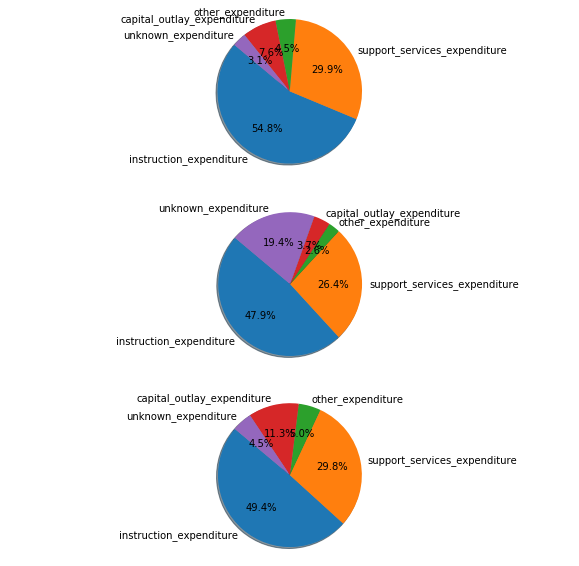

In [710]:
labelmap = clusterAnslysis(3, cluster_df)

In [711]:
finance_df.columns

Index(['state', 'year', 'enroll', 'total_revenue', 'federal_revenue',
       'state_revenue', 'local_revenue', 'total_expenditure',
       'instruction_expenditure', 'support_services_expenditure',
       'other_expenditure', 'capital_outlay_expenditure',
       'avg_attendence_elem_secd_schools', 'teachers_elem_secd_schools',
       'high_school_completers_18_to_24', 'bachelor_completers_over_25',
       'pupil_teacher_ratio', 'pub_high_school_graduates',
       'expenditure_per_pupil', 'edu_expenditure_percent_gov_income',
       'population', 'gdp_per_capita', 'income_per_capita',
       'known_property_crimes', 'unemployment_rate', 'unknown_expenditure'],
      dtype='object')

In [712]:
class_df = finance_df[['state', 'year', 'enroll',
       'avg_attendence_elem_secd_schools', 'teachers_elem_secd_schools',
       'high_school_completers_18_to_24', 'bachelor_completers_over_25',
       'pupil_teacher_ratio', 'pub_high_school_graduates',
       'expenditure_per_pupil', 'edu_expenditure_percent_gov_income',
       'population', 'gdp_per_capita', 'income_per_capita',
       'known_property_crimes', 'unemployment_rate']].copy()
# class_features = [ 'enroll',
#        'avg_attendence_elem_secd_schools', 'teachers_elem_secd_schools',
#        'high_school_completers_18_to_24', 'bachelor_completers_over_25',
#        'pupil_teacher_ratio', 'pub_high_school_graduates',
#        'expenditure_per_pupil', 'edu_expenditure_percent_gov_income',
#        'population', 'gdp_per_capita', 'income_per_capita',
#        'known_property_crimes', 'unemployment_rate']
class_features = [
       
       'high_school_completers_18_to_24', 'bachelor_completers_over_25',
        'pub_high_school_graduates',
       'expenditure_per_pupil', 'edu_expenditure_percent_gov_income',
       'population', 'gdp_per_capita', 'income_per_capita',
       'known_property_crimes', 'unemployment_rate']
class_df['label'] = class_df.state.map(labelmap)
class_df.head()

,state,year,enroll,avg_attendence_elem_secd_schools,teachers_elem_secd_schools,high_school_completers_18_to_24,bachelor_completers_over_25,pupil_teacher_ratio,pub_high_school_graduates,expenditure_per_pupil,edu_expenditure_percent_gov_income,population,gdp_per_capita,income_per_capita,known_property_crimes,unemployment_rate,label
0,Alabama,2000,730184.0,725212.0,48194.4,0.722477,0.190,15.354315,37819.0,5758.428628,0.250000,4452173.0,33284,24258,151127.0,0.045750,2
1,Alaska,2000,132822.0,122412.0,7880.4,0.769277,0.247,16.922491,6615.0,9668.161193,0.123966,627963.0,57184,31651,21074.0,0.063583,2
2,Arizona,2000,814807.0,782851.0,44438.4,0.692453,0.235,19.750846,38304.0,5478.359673,0.190000,5160586.0,39185,26232,271269.0,0.039750,2
3,Arkansas,2000,450751.0,422958.0,31947.4,0.754282,0.167,14.084370,27335.0,5627.818516,0.195000,2678588.0,31834,22784,97501.0,0.042750,2
4,California,2000,5941946.0,5957216.0,298021.4,0.707395,0.266,20.605279,309866.0,6400.553393,0.260000,33987977.0,48223,33095,1054010.0,0.049583,2


In [713]:
X = class_df[class_features]
y = class_df[class_df.columns[-1]]
treecls = RandomForestClassifier(n_estimators=500)
treecls.fit(X,y)
dict(zip(class_features, treecls.feature_importances_))

{'high_school_completers_18_to_24': 0.040092475053087794,
 'bachelor_completers_over_25': 0.08313806864130523,
 'pub_high_school_graduates': 0.17963723630355335,
 'expenditure_per_pupil': 0.08640256615033513,
 'edu_expenditure_percent_gov_income': 0.09752351263348494,
 'population': 0.22719432775476017,
 'gdp_per_capita': 0.10608324668257052,
 'income_per_capita': 0.033558311662254696,
 'known_property_crimes': 0.12129099043534977,
 'unemployment_rate': 0.025079264683298658}

# State time dependence analysis

In [932]:
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVR

In [938]:
incomes = ['enroll', 'total_revenue', 'federal_revenue',
       'state_revenue', 'local_revenue', 'total_expenditure',
       'instruction_expenditure', 'support_services_expenditure',
       'other_expenditure', 'capital_outlay_expenditure',
       'avg_attendence_elem_secd_schools', 'teachers_elem_secd_schools',
        'unknown_expenditure', 'pupil_teacher_ratio','population',
          'expenditure_per_pupil', 'edu_expenditure_percent_gov_income']

outcomes = ['high_school_completers_18_to_24', 'bachelor_completers_over_25',
       'pub_high_school_graduates',
       'edu_expenditure_percent_gov_income',
       'gdp_per_capita', 'income_per_capita',
       'known_property_crimes', 'unemployment_rate']

In [939]:
def timeDeptAnalysis(response, state = 'Texas'):
    global incomes, df
    state_df = df[df.state == state].copy()
    state_df = state_df.set_index('year')
    state_df = state_df.drop('state', axis = 1)
    state_df.index.name = None
    
    pca = PCA(n_components=1)
    pca.fit(state_df[incomes])
    state_df['pca_income'] = pca.transform(state_df[incomes]).flatten()

    after_years = np.arange(0, 12)
    years = list(state_df.index.unique())
    tree_score = []
    model_score = []
    for yr in after_years:
        year_pair = [(x, x + yr) for x in years if (x + yr) <= max(years)]
        model_score_temp = []
        tree_score_temp = []
        for i in range(200):
            X = np.c_[[state_df.loc[z[0],'pca_income'] for z in year_pair]]
            y = [state_df.loc[z[1],response] for z in year_pair]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)
            lr = LinearRegression()   
            lr.fit(X_train, y_train)
            model_score_temp.append(lr.score(X_test, y_test))


#             X = np.c_[[state_df.loc[z[0],incomes] for z in year_pair]]
#             X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 3)

#             treemd = RandomForestRegressor(n_estimators=100)
#             treemd.fit(X_train,y_train)
#             tree_score_temp.append(treemd.score(X_test, y_test))
        model_score.append(np.mean(model_score_temp))
        #tree_score.append(np.mean(tree_score_temp))

    fig, ax = plt.subplots(1,2)
    ax[0].plot(after_years, model_score, 'o-', label ='train_test')    
   # ax[0].plot(after_years, tree_score, 'o-', label = 'forest')
    ax[0].set_title(response)
    
    ax[1].plot(after_years, model_score, 'o-', label ='train_test')    
    #ax[1].plot(after_years, tree_score, 'o-', label = 'forest')
    ax[1].set_title(response)
    ax[1].set_ylim([0,1])
    #plt.ylim([0,1])
    plt.legend()
    plt.show()

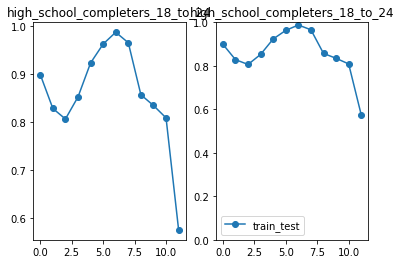

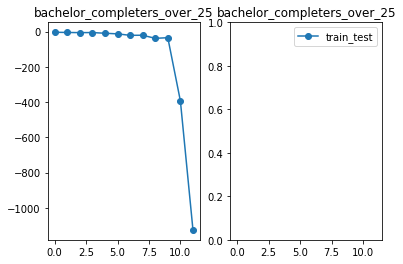

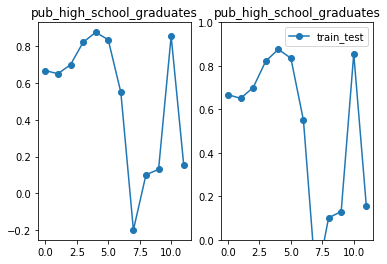

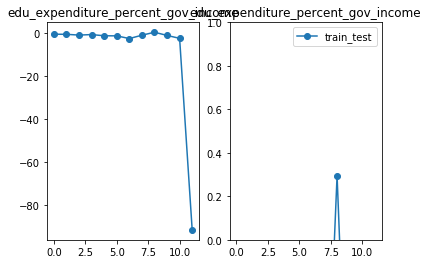

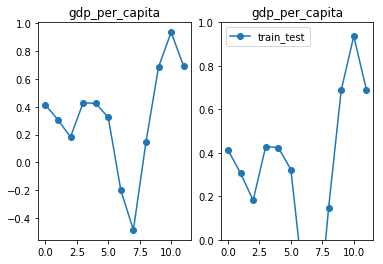

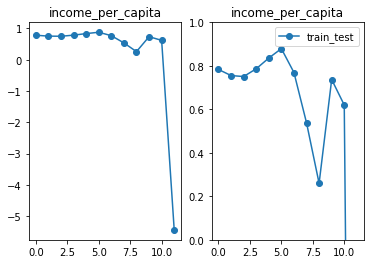

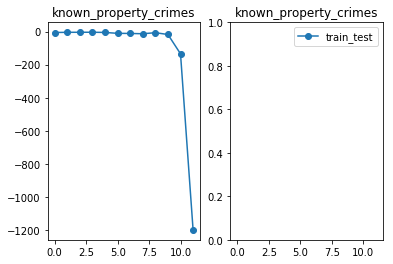

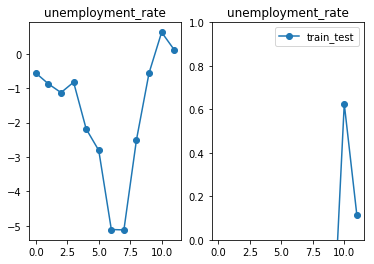

In [940]:
for r in outcomes:
    timeDeptAnalysis(r)

In [913]:
# texas_df = df[df.state == 'Texas']
# texas_df = texas_df.set_index('year')
# texas_df = texas_df.drop('state', axis = 1)
# texas_df.index.name = None
# texas_df.head()

In [912]:
# response = 'pub_high_school_graduates_pct_change'
# after_years = np.arange(0, 10)
# years = list(texas_df.index.unique())
# tree_score = []
# model_score = []
# for yr in after_years:
#     year_pair = [(x, x + yr) for x in years if (x + yr) <= max(years)]
#     model_score_temp = []
#     tree_score_temp = []
#     for i in range(50):
#         X = np.c_[[texas_df.loc[z[0],'pca_income'] for z in year_pair]]
#         y = [texas_df.loc[z[1],response] for z in year_pair]
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 3)
#         lr = LinearRegression(normalize=True)   
#         lr.fit(X_train, y_train)
#         model_score_temp.append(lr.score(X_test, y_test))


#         X = np.c_[[texas_df.loc[z[0],incomes] for z in year_pair]]
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 3)

#         treemd = RandomForestRegressor(n_estimators=100)
#         treemd.fit(X_train,y_train)
#         tree_score_temp.append(treemd.score(X_test, y_test))
#     model_score.append(np.mean(model_score_temp))
#     tree_score.append(np.mean(tree_score_temp))
    

# plt.plot(after_years, model_score, 'o-', label ='train_test')    

# plt.plot(after_years, tree_score, 'o-', label = 'forest')
# #plt.ylim([0,1])
# plt.legend()

## 2.3 change of revenue over years

In [406]:
plot_df = finance_df[['state', 'year'] + revenue_category]
plot_df = plot_df.melt(id_vars=['state', 'year'], value_vars=revenue_category, value_name='value', var_name='category')

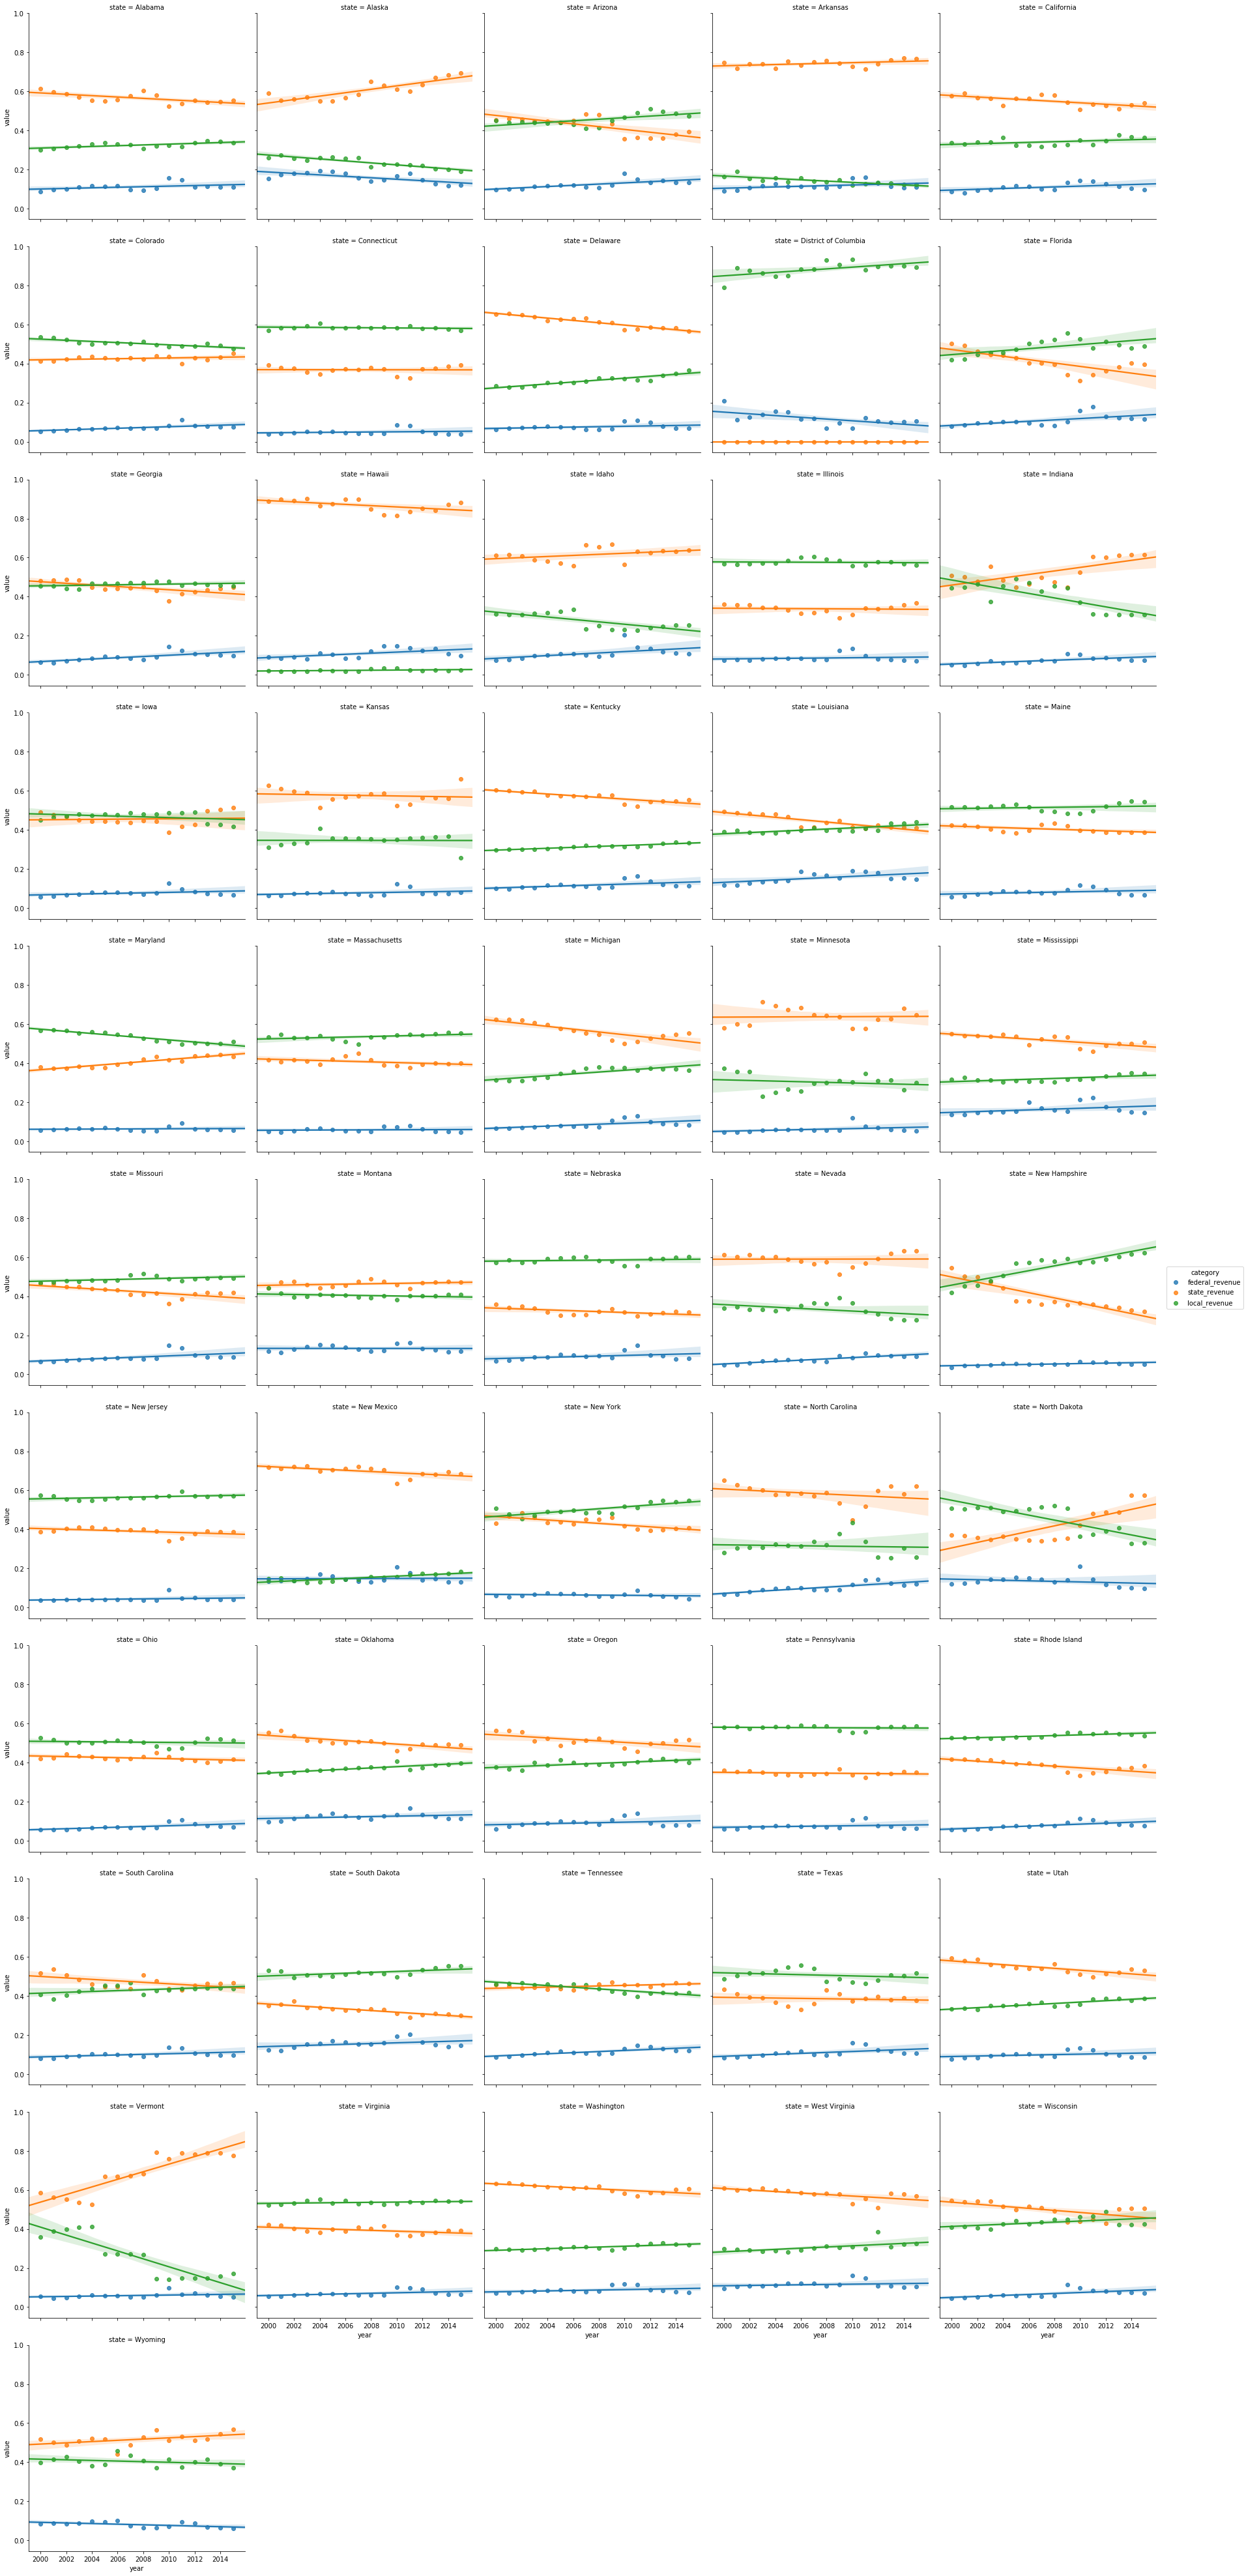

In [407]:
sns.lmplot(data = plot_df, x = 'year', y = 'value', hue = 'category', col = 'state', col_wrap = 5 )

# 3. Extract percent change rate for each individual states

In [941]:
for i,s in enumerate(df.state.unique()):    
    df1= df[df.state == s].copy()
    df1 = df1.sort_values(by = 'year').reset_index(drop = True)
    df1[df1.columns[2:]] = df1[df1.columns[2:]].pct_change()
    if i == 0:
        df_change = df1
    else:
        df_change = pd.concat([df_change, df1])
df_change = df_change.dropna(how = 'any')

In [942]:
df_change.columns = ['state', 'year'] + [x + '_pct_change' for x in df_change.columns[2:]]

In [943]:
df_change.head()

,state,year,enroll_pct_change,total_revenue_pct_change,federal_revenue_pct_change,state_revenue_pct_change,local_revenue_pct_change,total_expenditure_pct_change,instruction_expenditure_pct_change,support_services_expenditure_pct_change,...,pupil_teacher_ratio_pct_change,pub_high_school_graduates_pct_change,expenditure_per_pupil_pct_change,edu_expenditure_percent_gov_income_pct_change,population_pct_change,gdp_per_capita_pct_change,income_per_capita_pct_change,known_property_crimes_pct_change,unemployment_rate_pct_change,unknown_expenditure_pct_change
1,Alabama,2001,-0.002262,-0.010842,0.094305,-0.041340,0.021313,0.016545,0.041023,0.041857,...,-0.069452,-0.020713,0.050982,-0.040000,0.003473,0.000841,0.030629,-0.020162,0.114754,0.219194
2,Alabama,2002,-0.002972,0.061166,0.090690,0.045612,0.082030,0.012146,0.024222,0.029346,...,-0.050638,-0.010862,0.045476,-0.029167,0.002788,0.022695,0.019359,0.106652,0.156863,0.099016
3,Alabama,2003,0.002111,0.013161,0.116593,-0.014614,0.032451,0.029354,0.035423,0.075547,...,-0.032546,-0.004046,0.049758,-0.008584,0.005224,0.023101,0.040337,0.053853,0.021186,0.061819
4,Alabama,2004,0.003459,0.030804,0.102099,0.001530,0.058721,0.028560,0.020760,0.038905,...,-0.016785,-0.000580,0.025622,0.012987,0.006048,0.052991,0.070079,0.016491,-0.053942,0.072144
5,Alabama,2005,-0.001473,0.099672,0.064344,0.092896,0.123685,0.083371,0.061825,0.103349,...,-0.004643,0.027123,0.072912,0.000000,0.008625,0.023868,0.050439,-0.178198,-0.210526,0.196999


In [944]:
df_change.isnull().sum()

state                                            0
year                                             0
enroll_pct_change                                0
total_revenue_pct_change                         0
federal_revenue_pct_change                       0
state_revenue_pct_change                         0
local_revenue_pct_change                         0
total_expenditure_pct_change                     0
instruction_expenditure_pct_change               0
support_services_expenditure_pct_change          0
other_expenditure_pct_change                     0
capital_outlay_expenditure_pct_change            0
avg_attendence_elem_secd_schools_pct_change      0
teachers_elem_secd_schools_pct_change            0
high_school_completers_18_to_24_pct_change       0
bachelor_completers_over_25_pct_change           0
pupil_teacher_ratio_pct_change                   0
pub_high_school_graduates_pct_change             0
expenditure_per_pupil_pct_change                 0
edu_expenditure_percent_gov_inc

District of Columnbia is got removed, now only 50 states left

In [945]:
len(df_change.state.unique())

49

# 4. Interesting Outcome features (percent change)

+ public high school graduates (pecent change): pub_high_school_graduates_pct_change
+ bachelor completers over 25 years old: bachelor_completers_over_25_pct_change
+ Unemployment rate: unemployment_rate_pct_change
+ Known property crimes: known_property_crimes_pct_change
+ High school completers between age 18 to 24: high_school_completers_18_to_24_pct_change

## 4.1 pub_high_school_graduates

In [1017]:
def groupAnalysis(n_groups, dataframe, response): 
#     all_features = list(dataframe.columns)
#     features = all_features.copy()
#     if response in feature:
#         features.remove(response)
#     features.remove('state')
    global imt_features
    features = imt_features
    
    cluster_df = dataframe[['state','year', response]]
    cluster_df = cluster_df.pivot_table(index = 'state', columns = 'year', values = response)
    cluster_df.columns.name = None
    cluster_df = cluster_df.reset_index()
    
    km = KMeans(n_clusters=n_groups, random_state=42, n_init=100)
    km.fit(cluster_df.set_index('state'))
    
    labelmap = dict(zip(cluster_df.state, km.labels_))

    cluster_df['label'] = cluster_df.state.map(labelmap)
    
    labeled_df = dataframe.copy()
    labeled_df['label'] = labeled_df.state.map(labelmap)

    for i in labeled_df.label.unique():
        sns.kdeplot(labeled_df[labeled_df.label == i].pub_high_school_graduates_pct_change, label = 'group: '+ str(i))
    plt.show()
    X = labeled_df[features]
    y = labeled_df['label']
    
    temp = []
    for i in range(20):
        forest = RandomForestClassifier(n_estimators=200, max_features=3, max_depth = 3)
        forest.fit(X, y)
        temp.append(forest.feature_importances_)
    temp = np.average(np.array(temp), axis = 0)
    feature_df = pd.DataFrame(temp, index=features, columns = ['importance'])

    plt.figure(figsize = (10, 8))
    _=sns.barplot(data = feature_df.reset_index().sort_values(by = 'importance',ascending = False ),
                x = 'importance', y = 'index', palette='Reds_r')
    _= plt.ylabel('features')
    _= plt.title('Feature Importance for \n' + response)
    plt.show()
    
    
#     pd.DataFrame(fores.feature_importances_, index=features).plot(kind = 'bar')
#     plt.show()

In [1020]:
_ = ['enroll_pct_change', 'gdp_per_capita_pct_change']

imt_features = ['total_revenue_pct_change',
       'federal_revenue_pct_change', 'state_revenue_pct_change',
       'local_revenue_pct_change', 'total_expenditure_pct_change',
       'instruction_expenditure_pct_change',
       'support_services_expenditure_pct_change',
       'other_expenditure_pct_change', 'capital_outlay_expenditure_pct_change',
               'avg_attendence_elem_secd_schools_pct_change',
       'teachers_elem_secd_schools_pct_change','pupil_teacher_ratio_pct_change',
               'expenditure_per_pupil_pct_change',
       'edu_expenditure_percent_gov_income_pct_change',
       'income_per_capita_pct_change', 'known_property_crimes_pct_change',
       'unemployment_rate_pct_change', 'unknown_expenditure_pct_change']

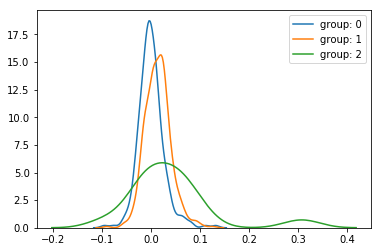

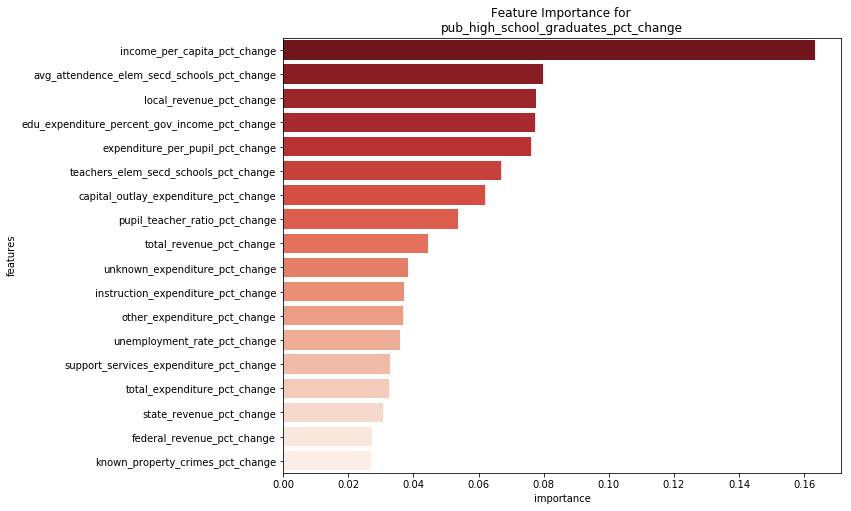

In [1021]:
groupAnalysis(3, df_change, 'pub_high_school_graduates_pct_change')

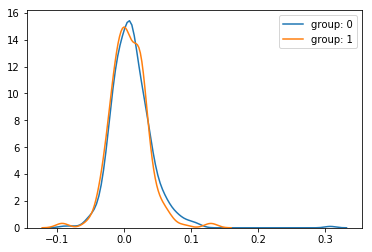

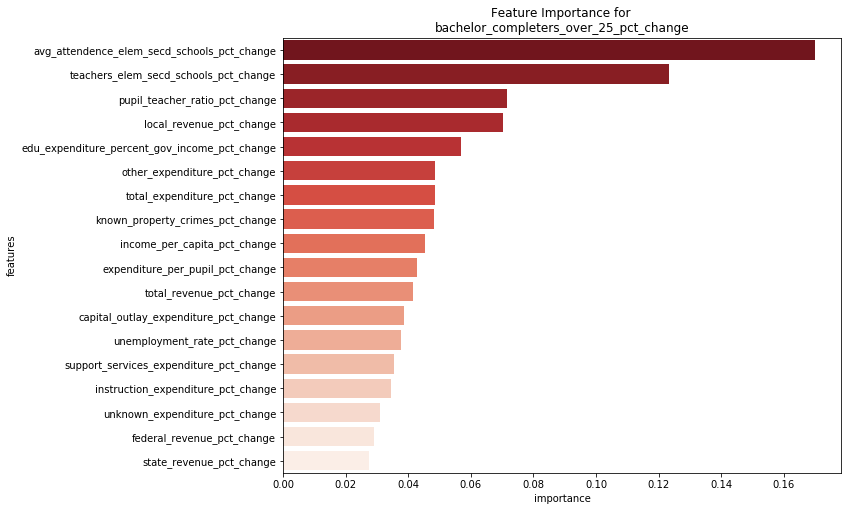

In [1022]:
groupAnalysis(2, df_change, 'bachelor_completers_over_25_pct_change')

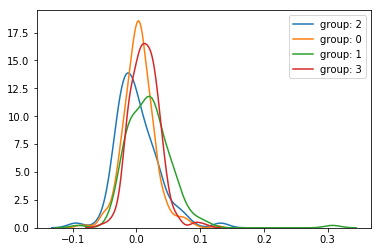

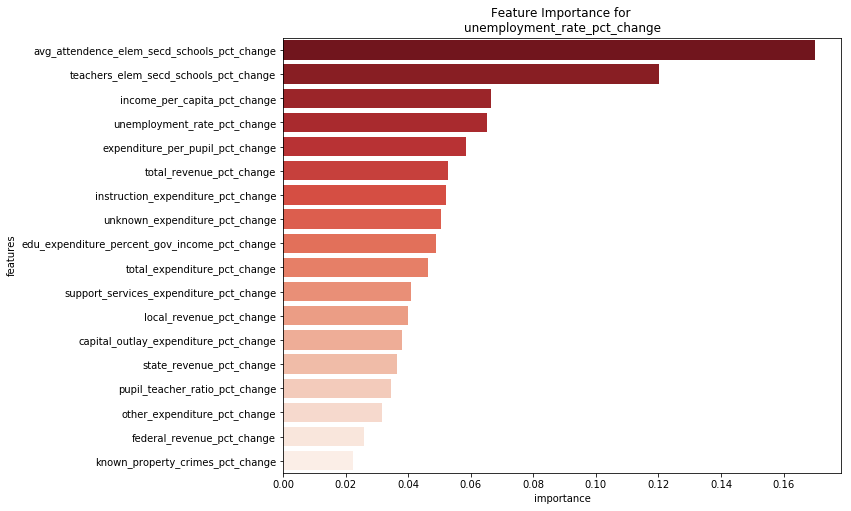

In [1024]:
groupAnalysis(4, df_change, 'unemployment_rate_pct_change')

In [341]:
response = 'pub_high_school_graduates_pct_change'
all_features = list(df_change.columns)
features = all_features.copy()
features.remove(response)
features.remove('state')

In [287]:
cluster_df = df_change[['state','year', 'pub_high_school_graduates_pct_change']]
cluster_df = cluster_df.pivot_table(index = 'state', columns = 'year', values = 'pub_high_school_graduates_pct_change')
cluster_df.columns.name = None
cluster_df = cluster_df.reset_index()

In [288]:
cluster_df.head()

,state,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Alabama,-0.020713,-0.010862,-0.004046,-0.000580,0.027123,0.012416,0.026214,0.062551,0.017801,0.025759,0.066464,-0.013924,-0.025576,0.006941,0.015043
1,Alaska,0.054273,0.026435,0.009488,0.001343,-0.045191,0.065422,0.041435,0.024654,0.019478,0.029595,-0.021953,-0.009301,-0.016147,-0.017812,-0.034974
2,Arizona,0.010914,0.033497,0.055986,0.076867,0.307418,-0.090877,0.034442,0.102102,0.011465,-0.019704,0.054412,-0.019605,-0.015821,0.072370,-0.017838
3,Arkansas,-0.000282,-0.000939,-0.001739,-0.002684,-0.020603,0.081477,-0.056408,0.057388,-0.023255,0.007806,-0.002511,0.007587,0.017911,0.023576,0.025329
4,California,0.021234,0.025378,0.028135,0.029599,0.034171,-0.032943,0.038211,0.050247,-0.006010,0.087768,0.013531,0.019970,0.008267,0.004702,-0.007522


In [289]:
# plt.figure(figsize = (10, 20))
# sns.barplot(data = df_change, y = 'state', x = 'pub_high_school_graduates_pct_change')

In [290]:
# plt.figure(figsize = (10, 20))
# sns.boxplot(data = df_change, y = 'state', x = 'pub_high_school_graduates_pct_change')

In [291]:
from sklearn.cluster import KMeans

In [292]:
km = KMeans(n_clusters=3, random_state=42, n_init=50)
km.fit(cluster_df.set_index('state'))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=50, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [293]:
labelmap = dict(zip(cluster_df.state, km.labels_))

cluster_df['label'] = cluster_df.state.map(labelmap)

In [295]:
cluster_df.head()

,state,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,label
0,Alabama,-0.020713,-0.010862,-0.004046,-0.000580,0.027123,0.012416,0.026214,0.062551,0.017801,0.025759,0.066464,-0.013924,-0.025576,0.006941,0.015043,1
1,Alaska,0.054273,0.026435,0.009488,0.001343,-0.045191,0.065422,0.041435,0.024654,0.019478,0.029595,-0.021953,-0.009301,-0.016147,-0.017812,-0.034974,0
2,Arizona,0.010914,0.033497,0.055986,0.076867,0.307418,-0.090877,0.034442,0.102102,0.011465,-0.019704,0.054412,-0.019605,-0.015821,0.072370,-0.017838,2
3,Arkansas,-0.000282,-0.000939,-0.001739,-0.002684,-0.020603,0.081477,-0.056408,0.057388,-0.023255,0.007806,-0.002511,0.007587,0.017911,0.023576,0.025329,1
4,California,0.021234,0.025378,0.028135,0.029599,0.034171,-0.032943,0.038211,0.050247,-0.006010,0.087768,0.013531,0.019970,0.008267,0.004702,-0.007522,0


In [296]:
labeled_df = df_change.copy()
labeled_df['label'] = labeled_df.state.map(labelmap)

for i in labeled_df.label.unique():
    sns.kdeplot(labeled_df[labeled_df.label == i].pub_high_school_graduates_pct_change, label = 'group: '+ str(i))


In [298]:
from sklearn.ensemble import RandomForestClassifier

In [299]:
X = labeled_df[features]
y = labeled_df['label']

forest = RandomForestClassifier(n_estimators=50)
forest.fit(X, y)

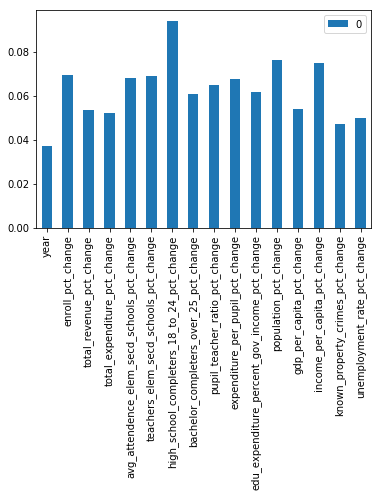

In [312]:
pd.DataFrame(forest.feature_importances_, index=features).plot(kind = 'bar')